# Machine Learning: CNN Architectures

## CNNs for Denoising 
### MNIST Dataset

Imports

In [55]:
import os
import datetime
import tensorflow as tf

Downloading the dataset (already splitted into train and test)

In [56]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()


In [57]:
print(train_images.shape, train_labels.shape)

(60000, 28, 28) (60000,)


In [58]:
# image preprocessing
NB_IMAGES_TO_USE = 1000

train_images = train_images[:NB_IMAGES_TO_USE] / 255.0
test_images = test_images[:NB_IMAGES_TO_USE]  / 255.0

In [59]:
print(train_images.shape, test_images.shape)

(1000, 28, 28) (1000, 28, 28)


### Plot images with random noise

In [60]:
import pylab as pl
import numpy as np

Text(0.5, 1.0, 'Noised (Input to the network)')

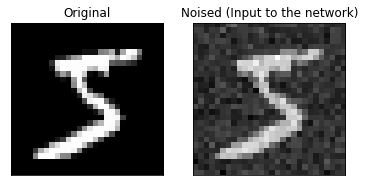

In [61]:
pl.subplot(121)
pl.imshow(train_images[0], cmap=pl.cm.gray) 
pl.xticks(())
pl.yticks(())
pl.title("Original")
pl.subplot(122)
pl.imshow(train_images[0] + np.random.normal(0., 0.1, (28, 28)), cmap=pl.cm.gray)
pl.xticks(())
pl.yticks(())
pl.title("Noised (Input to the network)")
#pl.show()

## UNet Architecture for MNIST Denoising 

### The architecture 

<img src="images/a_simple_unet.png" width="70%" height="30%"> 

As a reminder 
<img src="images/cnn_conv_design.png" width="70%" height="30%"> 

### Coding the model

In [62]:
# Encoder part

inputs = tf.keras.layers.Input(shape=(28, 28, 1))
x = tf.keras.layers.Conv2D(8, (3,3), activation="relu", padding="same")(inputs)
l1 = tf.keras.layers.Conv2D(8, (3,3), activation="relu", padding="same")(x)


x = tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same", strides=2)(l1) 
l2 = tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same")(x)


x = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same", strides=2)(l2) 
x = tf.keras.layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)

# Decoder part
x = tf.keras.layers.Conv2DTranspose(16, (3,3), activation="relu", padding="same", strides=2)(x)
x = tf.keras.layers.Concatenate()([x, l2])
x = tf.keras.layers.Conv2D(16, (3,3), activation="relu", padding="same")(x)


x = tf.keras.layers.Conv2DTranspose(8, (3,3), activation="relu", padding="same", strides=2)(x)
x = tf.keras.layers.Concatenate()([x, l1])
x = tf.keras.layers.Conv2D(8, (3,3), activation="relu", padding="same")(x)

# Output Layer
x = tf.keras.layers.Conv2D(1, (3,3), activation="sigmoid", padding="same")(x)

In [63]:
model = tf.keras.Model(inputs, x) 
model.compile(loss="binary_crossentropy", optimizer="adam")

In [64]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 28, 28, 8)    80          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 28, 28, 8)    584         conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 14, 14, 16)   1168        conv2d_20[0][0]                  
____________________________________________________________________________________________

## Image Generators

In [65]:
# Goes through the list of items in "images" 
# and return one value each time the function is called
def generator(images):
    while True:
        for im in images:
            noised = im + np.random.normal(0., 0.1, im.shape)
            noised = noised[np.newaxis]
            yield noised, im[np.newaxis]

In [66]:
train_gen = generator(train_images)

Input shape (1, 28, 28)
Output shape (1, 28, 28)


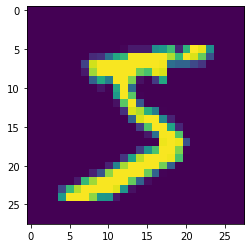

In [67]:
a, b = next(train_gen)
print("Input shape", a.shape)
print("Output shape", b.shape)
pl.imshow(np.squeeze(b))

### Training

In [68]:
# Adding an extra dimension 
print("Initial training set shape: ", train_images.shape)
train_images_extended = train_images[:,:,:,np.newaxis]
print("Extended training set shape: ", train_images_extended.shape)

Initial training set shape:  (1000, 28, 28)
Extended training set shape:  (1000, 28, 28, 1)


In [69]:
# define a folder to store the training data for monitoring
logdir = os.path.join("unet_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# give the previous folder to Tensorboard 
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

train_gen = generator(train_images_extended)
model.fit(train_gen, epochs=10, steps_per_epoch=20, callbacks=[tensorboard_callback])

  ...
    to  
  ['...']
Train for 20 steps
Epoch 1/10
20/20 [==============================] - 1s 42ms/step - loss: 0.6033
Epoch 2/10
20/20 [==============================] - 0s 7ms/step - loss: 0.4427
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.2307
Epoch 4/10
20/20 [==============================] - 0s 7ms/step - loss: 0.1391
Epoch 5/10
20/20 [==============================] - 0s 7ms/step - loss: 0.1216
Epoch 6/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0902
Epoch 7/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0817
Epoch 8/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0840
Epoch 9/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0766
Epoch 10/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0761


### Testing

In [70]:
test_im = test_images[5][np.newaxis, :,:, np.newaxis] + np.random.normal(0., 0.1, (1, 28, 28, 1))

In [71]:
outputs = model.predict(test_im)

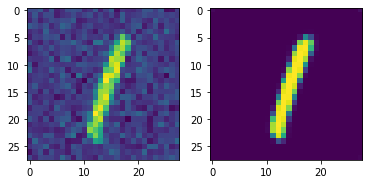

In [72]:
pl.subplot(121)
pl.imshow(np.squeeze(test_im))
pl.subplot(122)
pl.imshow(np.squeeze(outputs))

### Going further
1. Study the robustness by tweaking the noise
2. Add more layers 
 - Increase the layers on each levels
 - Increase the levels 3-4-5
3. Try on other datasets